In [0]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt


##Loading and visualizing data


In [0]:

#Load and prepare data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('fmnist', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('fmnist', download=True, train=False, transform=transform)
val_size= 0.2
batch_size= 100
num=len(trainset)
indices=list(range(num))
np.random.shuffle(indices)
split= int(np.floor(num*val_size))
train_idx, val_idx= indices[split:], indices[:split]
train_sampler= SubsetRandomSampler(train_idx)
val_sampler= SubsetRandomSampler(val_idx)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler= train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler= val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)



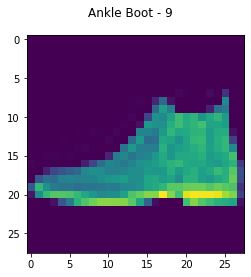

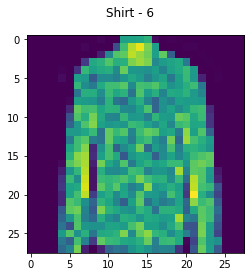

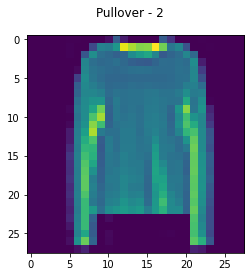

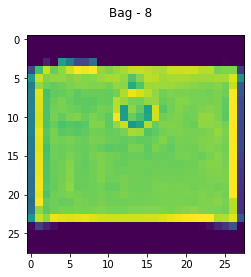

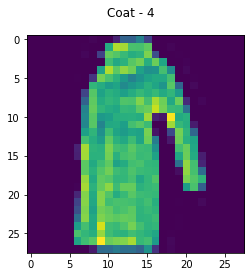

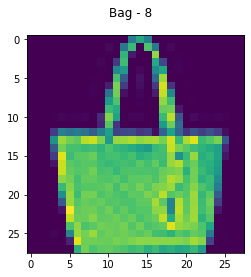

In [4]:
#Visualize Data

image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
			  4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
			  8:'Bag', 9:'Ankle Boot'}
for index, (images,labels) in enumerate(testloader):
	image=images[index][0]
	label = int(labels[index])
    
	plt.imshow(image)
	plt.suptitle(image_dict[label]+ ' - ' +str(label))
	plt.show()
	if index == 5:
		break
    

## Defining and Training Model


In [5]:
train_on_gpu= torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


In [6]:
from torch import nn, optim
import torch.nn.functional as f

class Convnet(nn.Module):
    def __init__(self):
        super(Convnet, self).__init__()
        self.conv1= nn.Conv2d(1, 32, 5, padding=2)
        self.pool= nn.MaxPool2d(2,2)
        
        self.batch_norm=nn.BatchNorm2d(32)
        self.conv2= nn.Conv2d(32,64,3, padding=1)
        self.fc1= nn.Linear(64*7*7, 2048)
        self.fc2= nn.Linear(2048,10)
        self.drop= nn.Dropout(0.2)
    def forward(self,x):
        x=self.pool(f.relu(self.conv1(x)))
        x=self.batch_norm(x)
        x=self.pool(f.relu(self.conv2(x)))
        x=self.drop(x)
        x=x.view(-1,64*7*7)
        x=f.relu(self.fc1(x))
        x=self.drop(x)
        x=self.fc2(x)
        return(x)
model=Convnet()
print(model)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9, nesterov=True)
epochs = 10
#print(epochs)
if train_on_gpu:
    model.cuda()
for e in range(epochs):
    running_loss = 0
    valid_loss=0
    model.train()
    #Training
    for images, labels in trainloader:
        if train_on_gpu:
            images, labels= images.cuda(), labels.cuda()
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()* images.size(0)
    #Validating
    model.eval()
    for images, labels in valloader:
        if train_on_gpu:
            images, labels= images.cuda(), labels.cuda()
        output=model(images)
        loss=criterion(output, labels)
        valid_loss+=loss.item()*images.size(0)
        
    running_loss = running_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(valloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, running_loss, valid_loss))



Convnet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)
Epoch: 0 	Training Loss: 0.465366 	Validation Loss: 0.310389
Epoch: 1 	Training Loss: 0.304018 	Validation Loss: 0.287083
Epoch: 2 	Training Loss: 0.258901 	Validation Loss: 0.247455
Epoch: 3 	Training Loss: 0.229767 	Validation Loss: 0.241135
Epoch: 4 	Training Loss: 0.207131 	Validation Loss: 0.236416
Epoch: 5 	Training Loss: 0.186873 	Validation Loss: 0.219517
Epoch: 6 	Training Loss: 0.168615 	Validation Loss: 0.231317
Epoch: 7 	Training Loss: 0.151451 	Validation Loss: 0.223183
E

## Testing


In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in testloader:
    if train_on_gpu:
        data, target= data.cuda(), target.cuda()
    output = model(data)
    
    loss = criterion(output, target) 
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


In [8]:
classes=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]

test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.240732

Test Accuracy of T-shirt/top: 91% (916/1000)
Test Accuracy of Trouser: 98% (986/1000)
Test Accuracy of Pullover: 88% (882/1000)
Test Accuracy of Dress: 91% (911/1000)
Test Accuracy of  Coat: 89% (893/1000)
Test Accuracy of Sandal: 98% (986/1000)
Test Accuracy of Shirt: 69% (696/1000)
Test Accuracy of Sneaker: 98% (980/1000)
Test Accuracy of   Bag: 98% (986/1000)
Test Accuracy of Ankle Boot: 95% (950/1000)

Test Accuracy (Overall): 91% (9186/10000)
